In [2]:
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [3]:
with open('distort_calibration.pickle', 'rb') as f:
    dist_info = pickle.load(f)

In [4]:
def undistort(img, dist_info):
    return cv2.undistort(img, dist_info['mtx'], dist_info['dist'], None, dist_info['mtx'])

In [5]:
images = glob.glob('test_images/*')

In [6]:
images

['test_images/test4.jpg',
 'test_images/test1.jpg',
 'test_images/straight_lines1.jpg',
 'test_images/test6.jpg',
 'test_images/test5.jpg',
 'test_images/test3.jpg',
 'test_images/test2.jpg',
 'test_images/straight_lines2.jpg']

In [961]:
def abs_sobel(img, orient='x', sobel_kernel=5):
    """ img should already be grayscale """
    ret = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1*(orient=='x'), 1*(orient=='y'), ksize=sobel_kernel))
    return ret

def sobel_magnitude(sx, sy, wx=1, wy=1):
    return np.sqrt(wx*sx**2+wy*sy**2)

def sobel_magnitude_thresh(sx, sy, wx=1, wy=1, thresh=(0.3,1)):
    height_middle = int(sx.shape[0]/2)
    mag = sobel_magnitude(sx, sy, wx, wy)
    mag = mag/np.max(mag[height_middle:,:])
    ret = np.zeros_like(mag)
    ret[(mag>=thresh[0]) & (mag<=thresh[1])] = 1
    return ret

def sobel_direction_thresh(sx, sy, thresh=(np.pi/6, np.pi/6*2.5)):
    dr = np.arctan2(sy, sx)
    ret = np.zeros_like(dr)
    ret[(dr>=thresh[0]) & (dr<=thresh[1])] = 1
    return ret

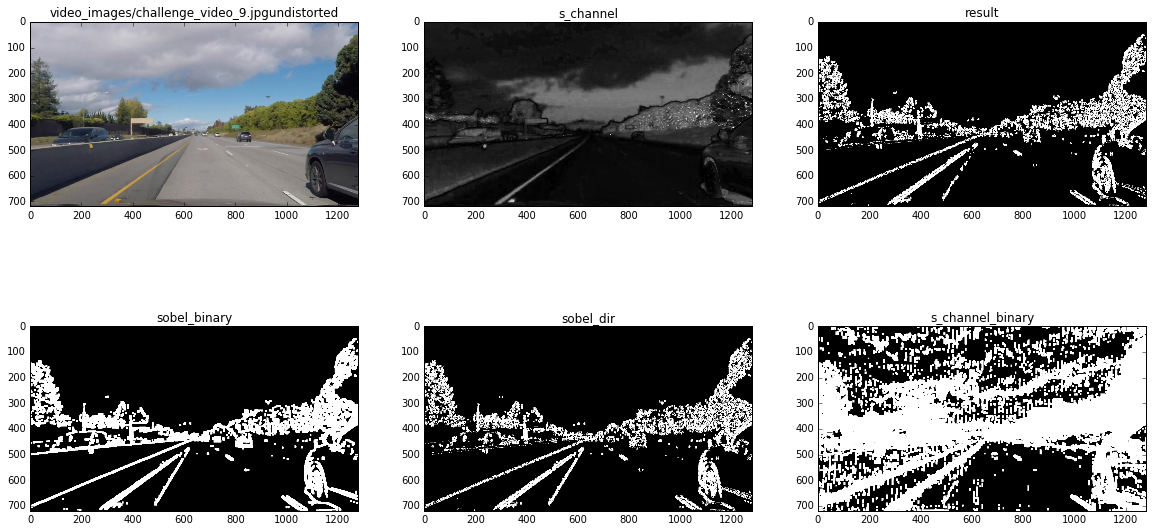

In [1391]:
f = 'video_images/challenge_video_9.jpg'
# f = 'video_images/project_video_9.jpg'
# f = images[7]
img = cv2.imread(f)
img_ud = undistort(img, dist_info)
img_size = (img_ud.shape[1], img_ud.shape[0])
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.imshow(img_ud[:,:,::-1])
plt.title(f + 'undistorted')
hls = cv2.cvtColor(img_ud, cv2.COLOR_BGR2HLS)
plt.subplot(2,3,2)
plt.imshow(hls[:,:,-1].astype(np.uint8), cmap='gray')
plt.title('s_channel')
gray = img_ud[:,:,-1]
sobel_x = abs_sobel(gray, orient='x')
sobel_y = abs_sobel(gray, orient='y')
sobel_rel_mag = sobel_magnitude_thresh(sobel_x, sobel_y, wy=0.05, thresh=(0.1,1))
sobel_rel_mag = np.clip(cv2.filter2D(sobel_rel_mag,-1,np.ones((7,7))),0,1)

sobel_dir = sobel_direction_thresh(sobel_x, sobel_y, thresh=(np.pi/2.5, np.pi/2))
# sobel_dir = np.clip(cv2.filter2D(sobel_dir, -1, np.ones((3,3))),0,1)
sobel_dir = (1-sobel_dir) * sobel_rel_mag
# sobel_dir = 1-np.clip(cv2.filter2D(sobel_dir, -1, np.ones((7,7))), 0, 1)
# sobel_dir = np.clip(cv2.filter2D(sobel_dir, -1, np.ones((7,7))), 0, 1)
s_channel = hls[:,:,2]
# s_channel = (s_channel > 160)
s_channel = sobel_magnitude_thresh(abs_sobel(s_channel, orient='x', sobel_kernel=5), \
                                   abs_sobel(s_channel, orient='y', sobel_kernel=5), \
                                   wy=0.1, thresh=(0.02,1))
s_channel = np.clip(cv2.filter2D(s_channel,-1,np.ones((7,7))),0,1)
plt.subplot(2,3,3)
res = 255*(s_channel*sobel_rel_mag*sobel_dir).astype(np.uint8)
plt.imshow(res, cmap='gray')
plt.title('result')
plt.subplot(2,3,4)
plt.imshow(255*sobel_rel_mag, cmap='gray')
plt.title('sobel_binary')
plt.subplot(2,3,5)
plt.imshow(255*sobel_dir, cmap='gray')
plt.title('sobel_dir')
plt.subplot(2,3,6)
plt.imshow(s_channel, cmap='gray')
plt.title('s_channel_binary')


In [1392]:
# pp_src = np.array([(200,720-36),(1120,720-36),(580,720-268),(705,720-268)]).astype(np.float32)
pp_src = np.array([(200,720-36),(1120,720-36),(580-38,720-268+23),(705+38,720-268+23)]).astype(np.float32)
pp_dst = np.array([(320,720),(960,720),(320,0),(960,0)]).astype(np.float32)
pp_mtx = cv2.getPerspectiveTransform(pp_src, pp_dst)
pp_mtx_inv = cv2.getPerspectiveTransform(pp_dst, pp_src)

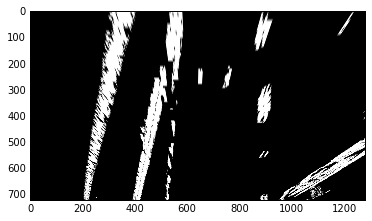

In [1393]:
img_pp = cv2.warpPerspective(res, pp_mtx, img_size)
plt.imshow(img_pp[:,:], cmap='gray')

In [1394]:
def pixel_in_windows(img, window_centroids, window_width, window_height, sample_ratio = 0.2):
    """ img has value either 0 or 255 """
    offset = window_width / 2
    level = img.shape[0]
    resultx, resulty = None, None
    for c in window_centroids:
        if c:
            y_min = int(c-offset)
            y_max = int(c+offset)
            x_min = level-window_height
            x_max = level
            retx, rety = np.where(img[x_min:x_max,y_min:y_max]==255)
            if retx.shape[0]>0:
                # prob = min(sample_size / retx.shape[0], 1)
                prob = sample_ratio
                sample_prob = (np.random.random(retx.shape[0])<=prob)
                retx, rety = retx[sample_prob], rety[sample_prob]
                if retx.shape[0] > 0:
                    retx += x_min
                    rety += y_min
                    if resultx is not None:
                        resultx = np.hstack([resultx, retx])
                        resulty = np.hstack([resulty, rety])
                    else:
                        resultx, resulty = retx, rety
        level -= window_height
    return resultx, resulty
        

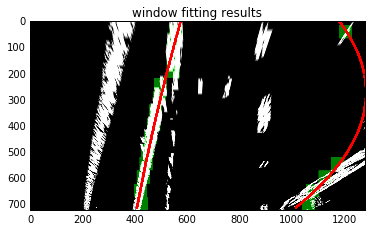

In [1395]:
warped = img_pp
# window settings
window_width = 50 
window_height = 50 # Break image into 9 vertical layers since image height is 720
margin = 50 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),\
           max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    offset = window_width/2

    # density threshold for level estimate
    mask_thresh = window_height*5*255
    
    # fractional height and threshold of the initial estimate
    init_frac = 1/4
    init_thresh = warped.shape[0]*init_frac / window_height * mask_thresh
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    
    l_center, r_center = None, None
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 

    # Go through each layer looking for max pixel locations
    for level in range(0,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[\
                int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        init_layer = np.sum(warped[\
                int(warped.shape[0]-level*window_height-warped.shape[0]*init_frac):int(warped.shape[0]-level*window_height), :], axis=0)
        conv_signal = np.convolve(window, image_layer)
        init_conv_signal = np.convolve(window, init_layer)
        
        if l_center:
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
            conv_ptr = conv_signal
        else:
            l_min_index = int(warped.shape[1]*0.15)
            l_max_index = int(warped.shape[1]*0.45)
            conv_ptr = init_conv_signal
        l_center_new = np.argmax(conv_ptr[l_min_index:l_max_index])+l_min_index-offset
        l_center_new = l_center_new.astype(np.int)
        l_center_offset = min(l_center_new+offset, warped.shape[1]).astype(np.int)
        if conv_ptr[l_center_offset] > mask_thresh:
            l_center = l_center_new
        else:
            l_center_new = None
        
        if r_center:
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
            conv_ptr = conv_signal
        else:
            r_min_index = int(warped.shape[1]*0.55+offset)
            r_max_index = int(warped.shape[1]*0.85)
            conv_ptr = init_conv_signal
        r_center_new = np.argmax(conv_ptr[r_min_index:r_max_index])+r_min_index-offset
        r_center_new = r_center_new.astype(np.int)
        r_center_offset = min(r_center_new+offset, warped.shape[1]).astype(np.int)
        if conv_ptr[r_center_offset] > mask_thresh:
            r_center = r_center_new
        else:
            r_center_new = None
        
        window_centroids.append((l_center_new, r_center_new))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)
lx, ly = pixel_in_windows(warped, [u for u,v in window_centroids], window_width, window_height)
pl = np.polyfit(lx, ly, 2)
rx, ry = pixel_in_windows(warped, [v for u,v in window_centroids], window_width, window_height)
pr = np.polyfit(rx, ry, 2)
result = np.zeros_like(warped)
for level in range(0,len(window_centroids)):
    if window_centroids[level][0]:
        result += window_mask(window_width,window_height,warped,window_centroids[level][0],level)
    if window_centroids[level][1]:
        result += window_mask(window_width,window_height,warped,window_centroids[level][1],level)
result[result>0] = 255
result = result.astype(np.uint8)
zero_channel = np.zeros_like(result)
linex = np.arange(0,720,10).astype(np.float32)
linely = np.polyval(pl, linex).astype(np.float32)
linery = np.polyval(pr, linex).astype(np.float32)
# print(np.vstack([linely,linex]).T.reshape(-1,1,2))

# make window pixels green
result = np.array(cv2.merge((zero_channel,result,zero_channel)),np.uint8) 

# making the original road pixels 3 color channels
warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) 
output = cv2.addWeighted(warpage, 1, result, 0.5, 0.0) # overlay the orignal road image with window results
cv2.polylines(output, [np.vstack([linely,linex]).T.reshape(-1,1,2).astype(np.int32), \
                      np.vstack([linery,linex]).T.reshape(-1,1,2).astype(np.int32)], False, (255,0,0),10)

'''
# Points used to draw all the left and right windows
l_points = np.zeros_like(warped)
r_points = np.zeros_like(warped)

# Go through each level and draw the windows 	
for level in range(0,len(window_centroids)):
    # Window_mask is a function to draw window areas
    if window_centroids[level][0]:
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
    if window_centroids[level][1]:
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

# Draw the results
template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
zero_channel = np.zeros_like(template) # create a zero color channel
template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
'''
# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


In [1396]:
# Define conversions in x and y from pixels space to meters
xm_per_pix = 30/720 # meters per pixel in v dimension
ym_per_pix = 3.7/700 # meters per pixel in h dimension
x_eval = 720

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lx*xm_per_pix, ly*ym_per_pix, 2)
right_fit_cr = np.polyfit(rx*xm_per_pix, ry*ym_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*x_eval*xm_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*x_eval*xm_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm', 2/(1/left_curverad+1/right_curverad))
print(left_fit_cr, right_fit_cr)
print(np.polyval(left_fit_cr,x_eval*xm_per_pix), \
      np.polyval(right_fit_cr,x_eval*xm_per_pix), \
      (np.polyval(left_fit_cr,x_eval*xm_per_pix)+np.polyval(right_fit_cr,x_eval*xm_per_pix))/2, \
      ym_per_pix*1280/2)

2493.49408487 m 121.382367525 m 231.495614375
[  2.00693618e-04  -3.59382851e-02   3.04149486e+00] [ -4.27627777e-03   9.76403095e-02   6.21042187e+00]
2.14397056055 5.29098115909 3.71747585982 3.382857142857143


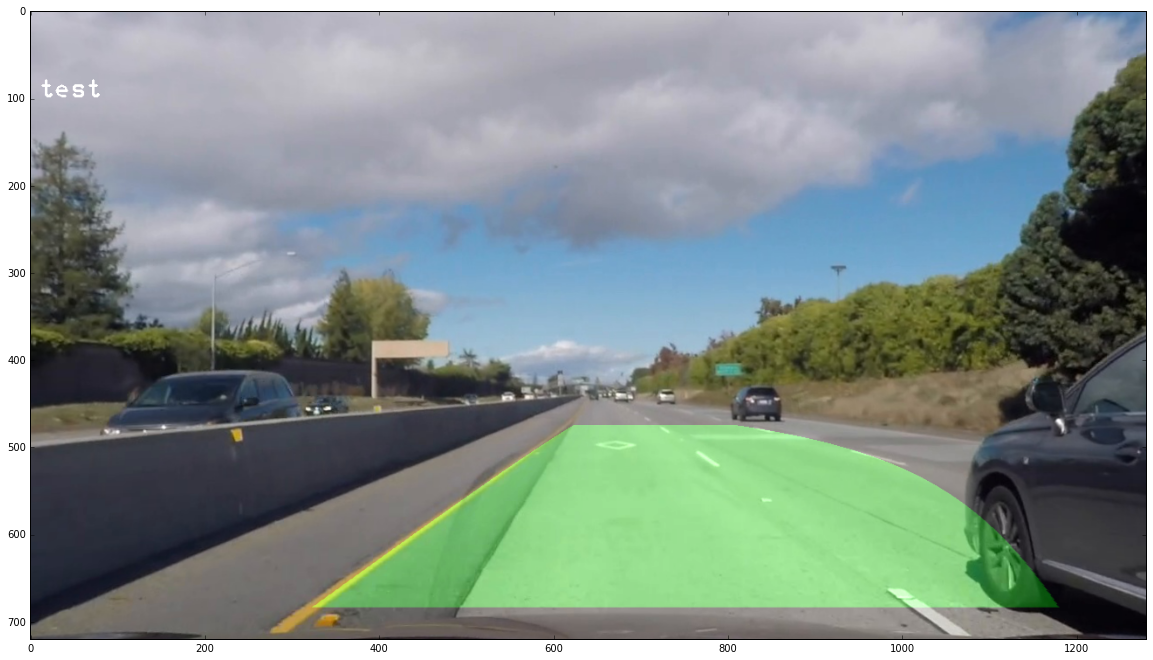

In [1397]:
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_y = np.arange(0, warped.shape[0], 1)
pts_lx = pl[0]*pts_y**2 + pl[1]*pts_y + pl[2]
pts_rx = pr[0]*pts_y**2 + pr[1]*pts_y + pr[2]

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([pts_lx, pts_y]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([pts_rx, pts_y])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, pp_mtx_inv, (img_ud.shape[1], img_ud.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img_ud, 1, newwarp, 0.3, 0)
cv2.putText(result, 'test', (10,100), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2)
plt.figure(figsize=(20,11.25))
plt.imshow(result[:,:,::-1])